In [1]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
#declare sampling rate
sampling_rate = 16000#read data
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')
bird_df.shape

(940, 9)

In [3]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(657, 9)

In [4]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(283, 9)

In [5]:
#get the audio path
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [6]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 2.5,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [41]:
#generate gaussian noise on one of the frames
def generate_gaussian_noise(length, mean=0, std=0.003):
    gaussian_noise = np.random.normal(mean, std, length)
    return gaussian_noise

In [46]:
#extract mfcc from frames
def extract_mfcc_and_chroma_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20, n_chroma=12):
  mfcc_frames = []
  chroma_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Add Gaussian noise to the copied frame
    gaussian_noise = generate_gaussian_noise(len(frame))
    frame += gaussian_noise


    #Extract mfcc from the main audio frame and augmented frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    # Extract chroma from the main audio frame
    chroma = librosa.feature.chroma_stft(y=frame, sr=sample_rate, n_chroma=n_chroma)

    # Transpose the chroma matrix
    transposed_chroma = chroma.T

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)

    #append the labels for every frame
    target_label.append(class_label)

  #Combine MFCC and chroma features for each frame
  combined_frames = [np.hstack((mfcc, chroma)) for mfcc, chroma in zip(mfcc_frames, chroma_frames)]

  return mfcc_frames,target_label

In [45]:
#Define the function to extract the final features (MFCC and Chroma)
def extract_final_features_from_dataframe(df, n_mfcc=20, n_chroma=12):
    mfcc_and_chroma_frames = []
    target_labels = []

    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']

        if duration < 10:
            # Load the audio using the load_audio function
            audio = load_audio(file_name)
            # Calculate the time stretch factor to make the audio 10 seconds long
            time_stretch_factor = 10 / duration
            # Resample the audio to make it 10 seconds long
            audio_stretched = librosa.resample(audio, orig_sr=sampling_rate, target_sr=int(sampling_rate * time_stretch_factor))
            framed_audio = frame_audio(audio_stretched)  # Frame the time-stretched audio into 5-second segments
        else:
            # For audios with duration >= 10 seconds, proceed as before
            audio = load_audio(file_name)
            framed_audio = frame_audio(audio)

        # Extract MFCC and chroma features for each frame
        combined_frames, target_label = extract_mfcc_and_chroma_from_frames(framed_audio, class_label, n_mfcc=n_mfcc, n_chroma=n_chroma)
        mfcc_and_chroma_frames.extend(combined_frames)
        target_labels.extend(target_label)

    return mfcc_and_chroma_frames, target_labels

In [47]:
#let us get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [48]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [49]:
#lets scale the data, so that the features are all in a uniform range between 0 and 1
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [50]:
# Define the number of MFCC and chroma features
n_mfcc = 20
n_chroma = 12

# Extract the MFCC embeddings and labels from the model
mfcc_chroma_embeddings, labels = extract_final_features_from_dataframe(bird_train_df, n_mfcc=n_mfcc, n_chroma=n_chroma)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [51]:
mfcc_chroma_embeddings[:1]

[array([[-392.7774   ,   -3.177428 ,    2.3669963, ...,   -0.4070816,
            1.8201987,    0.9462404],
        [-306.1355   ,   26.014585 ,  -19.24738  , ...,   -3.8561273,
           -2.6328313,   -1.6362537],
        [-259.36145  ,   40.401596 ,  -34.058533 , ...,   -1.1556053,
           -2.6595943,   -0.4518757],
        ...,
        [-256.7884   ,   32.50169  ,  -26.679478 , ...,   -8.944358 ,
           -1.3370847,    0.478809 ],
        [-252.10855  ,   24.314415 ,  -22.417572 , ...,    1.1975499,
            2.170434 ,   -2.4223838],
        [-276.82123  ,   19.504547 ,  -26.985287 , ...,    6.849592 ,
            1.0759202,   -5.6544905]], dtype=float32)]

In [52]:
#verify the shapes
x_train = np.array(mfcc_chroma_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(9292, 157, 20)
(9292,)


In [53]:
#lets extract the embeddings
val_mfcc_chroma_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [54]:
val_mfcc_chroma_embeddings[:2]

[array([[-2.95012390e+02,  8.74857254e+01,  4.87819138e+01, ...,
          4.81398869e+00,  3.93579721e+00,  9.14696598e+00],
        [-2.50427917e+02,  9.33089294e+01,  4.58537598e+01, ...,
          5.76293516e+00,  2.50962996e+00,  5.45079470e+00],
        [-2.45109467e+02,  9.46164703e+01,  4.26227760e+01, ...,
          9.41549778e-01,  3.44830608e+00,  3.52436304e+00],
        ...,
        [-2.25652130e+02,  1.14530632e+02,  5.00828857e+01, ...,
          7.70513415e-02,  1.44722378e+00, -8.09486508e-01],
        [-2.26367554e+02,  1.11689194e+02,  4.44051743e+01, ...,
          4.99983740e+00,  4.34495831e+00,  3.26367664e+00],
        [-2.46511078e+02,  1.09914085e+02,  4.08561935e+01, ...,
          3.52333212e+00, -1.82875812e-01,  2.50065494e+00]], dtype=float32),
 array([[-2.5537193e+02,  1.0804545e+02,  4.3540047e+01, ...,
          2.0969613e+00,  2.1187457e-01,  1.8889266e-01],
        [-2.3450801e+02,  1.0877995e+02,  5.0868866e+01, ...,
          3.1538734e+00,  1.3722

In [55]:
#verify the val data shapes
x_val = np.array(val_mfcc_chroma_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(3734, 157, 20)
(3734,)


In [56]:
#lets call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)

In [57]:
#lets verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(9292, 3)
(3734, 3)


In [58]:
#call the scale function and make all the features in a uniform scale
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)

In [59]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

(9292, 157, 20)
(9292, 3)
(3734, 157, 20)
(3734, 3)


In [118]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import numpy as np

def create_transfer_learning_model(lstm_model, n_classes, num_frames, num_features):
    # Step 3: Create a new model with LSTM layers up to the last LSTM layer
    input_layer = Input(shape=(num_frames, num_features))
    x = lstm_model.layers[0](input_layer)
    for layer in lstm_model.layers[1:-1]:  # Exclude the last layer (output layer)
        x = layer(x)

    # Add a new dimension for sequence_length (to make the input 3D)
    x = tf.expand_dims(x, axis=-1)


    lstm_features_model = Model(inputs=input_layer, outputs=x)

    # Step 4: Freeze the weights of the LSTM layers
    for layer in lstm_features_model.layers:
        layer.trainable = False

    # Step 5: Add Your Own 1D CNN Layers
    cnn_model = tf.keras.Sequential()
    cnn_model.add(lstm_features_model)  # Add the pre-trained LSTM layers
    # Add 1D CNN layers
    cnn_model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=3))
    cnn_model.add(BatchNormalization())

    cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    cnn_model.add(BatchNormalization())  # Add BatchNormalization after each Conv1D layer
    cnn_model.add(MaxPooling1D(pool_size=3))


    cnn_model.add(GlobalAveragePooling1D())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(n_classes, activation='softmax'))


    learning_rate = 0.002 # You can adjust this value
    optimizer = Adam(learning_rate=learning_rate)


    # Compile the new model
    cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return cnn_model

In [119]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping


# Assuming x_train and x_val are your training and validation data
x_train_reshaped = np.expand_dims(x_shuffled_train, axis=-1)
x_val_reshaped = np.expand_dims(x_shuffled_val, axis=-1)

# Load the pre-trained LSTM model
lstm_model = load_model('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/2clstm_mfcc_chroma.model.h5')
n_classes = 3  # Change this to the number of classes in your classification task

num_frames = x_train_reshaped.shape[1]  # Update with the actual number of frames
num_features = x_train_reshaped.shape[2]  # Update with the actual number of features per frame

# Call the function to create the transfer learning model
cnn_model = create_transfer_learning_model(lstm_model, n_classes, num_frames, num_features)

# Define the early stopping callback
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)


# Train the CNN model with the reshaped data
history = cnn_model.fit(x_train_reshaped, y_shuffled_train, validation_data=(x_val_reshaped, y_shuffled_val), epochs=100, callbacks=[early_stopping])


Epoch 1/100
291/291 [==============================] - 82s 265ms/step - loss: 0.6668 - accuracy: 0.7321 - val_loss: 1.2753 - val_accuracy: 0.3307
Epoch 2/100
291/291 [==============================] - 79s 271ms/step - loss: 0.6275 - accuracy: 0.7478 - val_loss: 0.6764 - val_accuracy: 0.7461
Epoch 3/100
291/291 [==============================] - 77s 266ms/step - loss: 0.6171 - accuracy: 0.7490 - val_loss: 0.7390 - val_accuracy: 0.7258
Epoch 4/100
291/291 [==============================] - 78s 267ms/step - loss: 0.6065 - accuracy: 0.7536 - val_loss: 0.6263 - val_accuracy: 0.7354
Epoch 5/100
291/291 [==============================] - 78s 269ms/step - loss: 0.6061 - accuracy: 0.7569 - val_loss: 0.8191 - val_accuracy: 0.6851
Epoch 6/100
291/291 [==============================] - 78s 268ms/step - loss: 0.6079 - accuracy: 0.7565 - val_loss: 0.8907 - val_accuracy: 0.6993
Epoch 7/100
291/291 [==============================] - 77s 266ms/step - loss: 0.5919 - accuracy: 0.7644 - val_loss: 0.6063 -

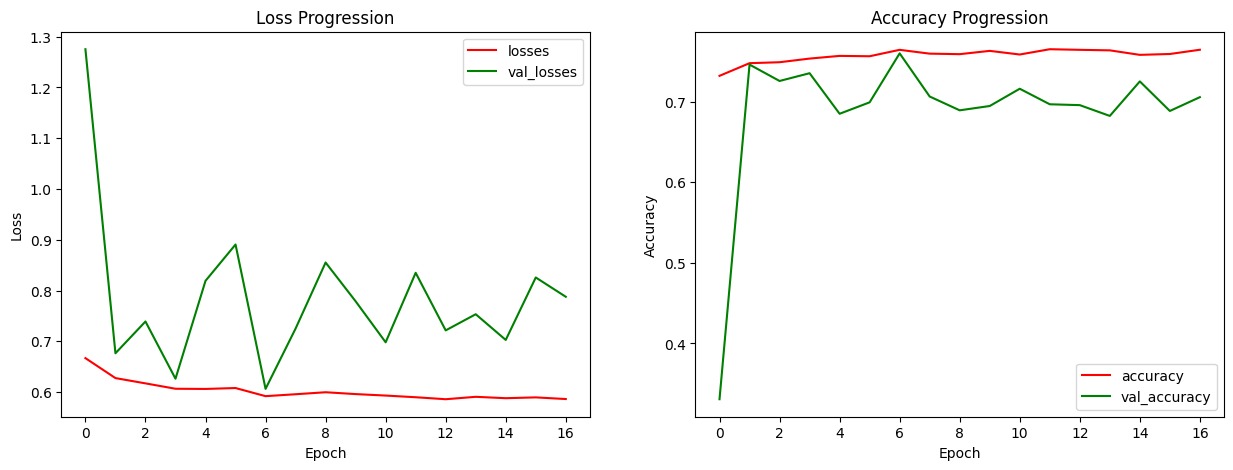

In [120]:
#plot the training and validation accuracy and losses
num_epochs = len(history.history['loss'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()

plt.show()

In [122]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(cnn_model.predict(x_shuffled_train), axis=-1)
print(test_pred_train)

291/291 [==============================] - 58s 197ms/step
[2 1 1 ... 0 2 0]


In [123]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred = np.argmax(cnn_model.predict(x_shuffled_val), axis=-1)
print(test_pred)

117/117 [==============================] - 27s 234ms/step
[2 2 1 ... 1 2 1]


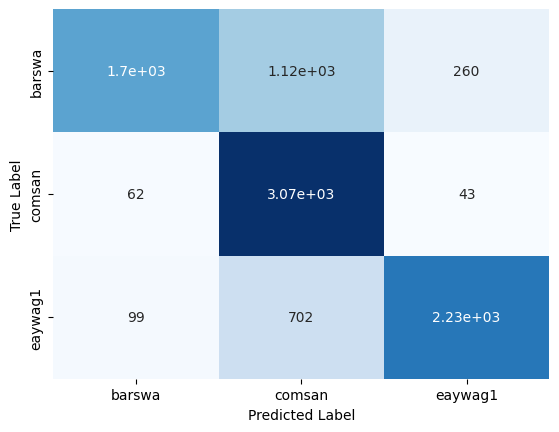

              precision    recall  f1-score   support

           0      0.914     0.552     0.688      3090
           1      0.627     0.967     0.760      3171
           2      0.880     0.736     0.802      3031

    accuracy                          0.753      9292
   macro avg      0.807     0.751     0.750      9292
weighted avg      0.805     0.753     0.750      9292



In [124]:
#Training accuracy plots
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

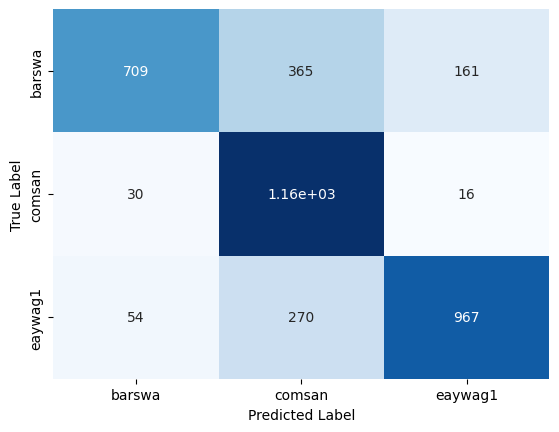

              precision    recall  f1-score   support

           0      0.894     0.574     0.699      1235
           1      0.647     0.962     0.773      1208
           2      0.845     0.749     0.794      1291

    accuracy                          0.760      3734
   macro avg      0.795     0.762     0.756      3734
weighted avg      0.797     0.760     0.756      3734



In [125]:
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))